In [1]:
%load_ext autoreload
%autoreload 2
import os 
os.chdir("/home/jadli/Bureau/BDAI2/Satellite_Super_Resulotion0")

import torch 
import torch.nn as nn
import torch.optim as optim

from importlib import reload    
import src.utils.config
reload(src.utils.config)
from src.utils.config import CONFIG

from src.utils.data_loader import create_loaders
from src.utils.models_architecture import EDSR       
from src.utils.train_model_sr import train_model_sr

best_model_path = CONFIG["model"]["best_EDSR_path"]
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device : {device}")

# CONFIG FROM YAML 
data_root      = CONFIG["paths"]["output_root"]
batch_size     = 32 #CONFIG["training"]["batch_size"]
num_workers    = CONFIG["training"]["num_workers"]
use_aug        = CONFIG["training"].get("use_augmentation", True)

# HYPERPARAMS FROM CONFIG 
lr              = CONFIG["training"]["lr"]
weight_decay    = CONFIG["training"]["weight_decay"]
num_epochs      = 70 #CONFIG["training"]["epochs"]
step_size       = CONFIG["training"]["scheduler_step_size"]
gamma           = CONFIG["training"]["scheduler_gamma"]


best_model_path = CONFIG["model"]["best_EDSR_path"]
last_model_path = CONFIG["model"]["last_EDSR_path"]

history_path = CONFIG["history"]["EDSR_history_path"]

# LOAD DATA 

train_loader, val_loader, test_loader = create_loaders(
    root=data_root,
    batch_size=batch_size,
    num_workers=num_workers,
    use_augmentation=use_aug
)

model = EDSR().to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=weight_decay)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 30, 45], gamma=0.5)

device : cuda

 DATA LOADED:
  Train: 152352 samples
  Val:   19044 samples
  Test:  19044 samples


 Training EDSR from scratch
No previous training history found.

 [EDSR] Epoch 1/60


 New BEST model saved at epoch 1 with PSNR = 26.80
Train loss: 0.041362 | Train PSNR: 24.15 dB
Val   loss: 0.031556 | Val   PSNR: 26.80 dB
-> LR: 0.00010000

 [EDSR] Epoch 2/60


 New BEST model saved at epoch 2 with PSNR = 27.08
Train loss: 0.034570 | Train PSNR: 24.96 dB
Val   loss: 0.030305 | Val   PSNR: 27.08 dB
-> LR: 0.00010000

 [EDSR] Epoch 3/60


 New BEST model saved at epoch 3 with PSNR = 27.27
Train loss: 0.033573 | Train PSNR: 25.13 dB
Val   loss: 0.029623 | Val   PSNR: 27.27 dB
-> LR: 0.00010000

 [EDSR] Epoch 4/60


 New BEST model saved at epoch 4 with PSNR = 27.43
Train loss: 0.032913 | Train PSNR: 25.26 dB
Val   loss: 0.028910 | Val   PSNR: 27.43 dB
-> LR: 0.00010000

 [EDSR] Epoch 5/60


 New BEST model saved at epoch 5 with PSNR = 27.54
Train loss: 0.032426 | Train PSNR: 25.38 dB
Val   loss: 0.028470 | Val   PSNR: 27.54 dB
-> LR: 0.00010000

 [EDSR] Epoch 6/60


 New BEST model saved at epoch 6 with PSNR = 27.56
Train loss: 0.032080 | Train PSNR: 25.46 dB
Val   loss: 0.028504 | Val   PSNR: 27.56 dB
-> LR: 0.00010000

 [EDSR] Epoch 7/60


 New BEST model saved at epoch 7 with PSNR = 27.64
Train loss: 0.031816 | Train PSNR: 25.52 dB
Val   loss: 0.028141 | Val   PSNR: 27.64 dB
-> LR: 0.00010000

 [EDSR] Epoch 8/60


 New BEST model saved at epoch 8 with PSNR = 27.68
Train loss: 0.031605 | Train PSNR: 25.57 dB
Val   loss: 0.028014 | Val   PSNR: 27.68 dB
-> LR: 0.00010000

 [EDSR] Epoch 9/60


 New BEST model saved at epoch 9 with PSNR = 27.74
Train loss: 0.031432 | Train PSNR: 25.61 dB
Val   loss: 0.027711 | Val   PSNR: 27.74 dB
-> LR: 0.00010000

 [EDSR] Epoch 10/60


 New BEST model saved at epoch 10 with PSNR = 27.75
Train loss: 0.031274 | Train PSNR: 25.64 dB
Val   loss: 0.027689 | Val   PSNR: 27.75 dB
-> LR: 0.00010000

 [EDSR] Epoch 11/60


 New BEST model saved at epoch 11 with PSNR = 27.81
Train loss: 0.031141 | Train PSNR: 25.67 dB
Val   loss: 0.027499 | Val   PSNR: 27.81 dB
-> LR: 0.00010000

 [EDSR] Epoch 12/60


 New BEST model saved at epoch 12 with PSNR = 27.85
Train loss: 0.031024 | Train PSNR: 25.70 dB
Val   loss: 0.027319 | Val   PSNR: 27.85 dB
-> LR: 0.00010000

 [EDSR] Epoch 13/60


 New BEST model saved at epoch 13 with PSNR = 27.87
Train loss: 0.030905 | Train PSNR: 25.73 dB
Val   loss: 0.027244 | Val   PSNR: 27.87 dB
-> LR: 0.00010000

 [EDSR] Epoch 14/60


 New BEST model saved at epoch 14 with PSNR = 27.90
Train loss: 0.030800 | Train PSNR: 25.75 dB
Val   loss: 0.027221 | Val   PSNR: 27.90 dB
-> LR: 0.00010000

 [EDSR] Epoch 15/60


 New BEST model saved at epoch 15 with PSNR = 27.93
Train loss: 0.030704 | Train PSNR: 25.77 dB
Val   loss: 0.027060 | Val   PSNR: 27.93 dB
-> LR: 0.00005000

 [EDSR] Epoch 16/60


 New BEST model saved at epoch 16 with PSNR = 27.96
Train loss: 0.030541 | Train PSNR: 25.81 dB
Val   loss: 0.026922 | Val   PSNR: 27.96 dB
-> LR: 0.00005000

 [EDSR] Epoch 17/60


 New BEST model saved at epoch 17 with PSNR = 27.97
Train loss: 0.030500 | Train PSNR: 25.82 dB
Val   loss: 0.026875 | Val   PSNR: 27.97 dB
-> LR: 0.00005000

 [EDSR] Epoch 18/60


 New BEST model saved at epoch 18 with PSNR = 27.99
Train loss: 0.030453 | Train PSNR: 25.83 dB
Val   loss: 0.026835 | Val   PSNR: 27.99 dB
-> LR: 0.00005000

 [EDSR] Epoch 19/60


 New BEST model saved at epoch 19 with PSNR = 27.99
Train loss: 0.030409 | Train PSNR: 25.83 dB
Val   loss: 0.026820 | Val   PSNR: 27.99 dB
-> LR: 0.00005000

 [EDSR] Epoch 20/60


 New BEST model saved at epoch 20 with PSNR = 28.00
Train loss: 0.030371 | Train PSNR: 25.84 dB
Val   loss: 0.026761 | Val   PSNR: 28.00 dB
-> LR: 0.00005000

 [EDSR] Epoch 21/60


Train loss: 0.030330 | Train PSNR: 25.85 dB
Val   loss: 0.026775 | Val   PSNR: 27.99 dB
-> LR: 0.00005000

 [EDSR] Epoch 22/60


 New BEST model saved at epoch 22 with PSNR = 28.02
Train loss: 0.030295 | Train PSNR: 25.86 dB
Val   loss: 0.026687 | Val   PSNR: 28.02 dB
-> LR: 0.00005000

 [EDSR] Epoch 23/60


 New BEST model saved at epoch 23 with PSNR = 28.03
Train loss: 0.030263 | Train PSNR: 25.87 dB
Val   loss: 0.026643 | Val   PSNR: 28.03 dB
-> LR: 0.00005000

 [EDSR] Epoch 24/60


 New BEST model saved at epoch 24 with PSNR = 28.04
Train loss: 0.030229 | Train PSNR: 25.87 dB
Val   loss: 0.026615 | Val   PSNR: 28.04 dB
-> LR: 0.00005000

 [EDSR] Epoch 25/60


 New BEST model saved at epoch 25 with PSNR = 28.05
Train loss: 0.030201 | Train PSNR: 25.88 dB
Val   loss: 0.026580 | Val   PSNR: 28.05 dB
-> LR: 0.00005000

 [EDSR] Epoch 26/60


 New BEST model saved at epoch 26 with PSNR = 28.05
Train loss: 0.030171 | Train PSNR: 25.89 dB
Val   loss: 0.026572 | Val   PSNR: 28.05 dB
-> LR: 0.00005000

 [EDSR] Epoch 27/60


 New BEST model saved at epoch 27 with PSNR = 28.07
Train loss: 0.030145 | Train PSNR: 25.89 dB
Val   loss: 0.026532 | Val   PSNR: 28.07 dB
-> LR: 0.00005000

 [EDSR] Epoch 28/60


 New BEST model saved at epoch 28 with PSNR = 28.08
Train loss: 0.030117 | Train PSNR: 25.90 dB
Val   loss: 0.026495 | Val   PSNR: 28.08 dB
-> LR: 0.00005000

 [EDSR] Epoch 29/60


 New BEST model saved at epoch 29 with PSNR = 28.08
Train loss: 0.030090 | Train PSNR: 25.90 dB
Val   loss: 0.026478 | Val   PSNR: 28.08 dB
-> LR: 0.00005000

 [EDSR] Epoch 30/60


Train loss: 0.030066 | Train PSNR: 25.91 dB
Val   loss: 0.026495 | Val   PSNR: 28.07 dB
-> LR: 0.00002500

 [EDSR] Epoch 31/60


 New BEST model saved at epoch 31 with PSNR = 28.10
Train loss: 0.030004 | Train PSNR: 25.92 dB
Val   loss: 0.026417 | Val   PSNR: 28.10 dB
-> LR: 0.00002500

 [EDSR] Epoch 32/60


 New BEST model saved at epoch 32 with PSNR = 28.10
Train loss: 0.029991 | Train PSNR: 25.93 dB
Val   loss: 0.026401 | Val   PSNR: 28.10 dB
-> LR: 0.00002500

 [EDSR] Epoch 33/60


Train loss: 0.029977 | Train PSNR: 25.93 dB
Val   loss: 0.026389 | Val   PSNR: 28.10 dB
-> LR: 0.00002500

 [EDSR] Epoch 34/60


 New BEST model saved at epoch 34 with PSNR = 28.11
Train loss: 0.029966 | Train PSNR: 25.93 dB
Val   loss: 0.026377 | Val   PSNR: 28.11 dB
-> LR: 0.00002500

 [EDSR] Epoch 35/60


Train loss: 0.029954 | Train PSNR: 25.93 dB
Val   loss: 0.026395 | Val   PSNR: 28.10 dB
-> LR: 0.00002500

 [EDSR] Epoch 36/60


 New BEST model saved at epoch 36 with PSNR = 28.11
Train loss: 0.029941 | Train PSNR: 25.94 dB
Val   loss: 0.026360 | Val   PSNR: 28.11 dB
-> LR: 0.00002500

 [EDSR] Epoch 37/60


 New BEST model saved at epoch 37 with PSNR = 28.12
Train loss: 0.029931 | Train PSNR: 25.94 dB
Val   loss: 0.026343 | Val   PSNR: 28.12 dB
-> LR: 0.00002500

 [EDSR] Epoch 38/60


 New BEST model saved at epoch 38 with PSNR = 28.12
Train loss: 0.029920 | Train PSNR: 25.94 dB
Val   loss: 0.026336 | Val   PSNR: 28.12 dB
-> LR: 0.00002500

 [EDSR] Epoch 39/60


Train loss: 0.029907 | Train PSNR: 25.94 dB
Val   loss: 0.026327 | Val   PSNR: 28.12 dB
-> LR: 0.00002500

 [EDSR] Epoch 40/60


Train loss: 0.029899 | Train PSNR: 25.94 dB
Val   loss: 0.026313 | Val   PSNR: 28.12 dB
-> LR: 0.00002500

 [EDSR] Epoch 41/60


Train loss: 0.029888 | Train PSNR: 25.95 dB
Val   loss: 0.026321 | Val   PSNR: 28.12 dB
-> LR: 0.00002500

 [EDSR] Epoch 42/60


 New BEST model saved at epoch 42 with PSNR = 28.14
Train loss: 0.029877 | Train PSNR: 25.95 dB
Val   loss: 0.026273 | Val   PSNR: 28.14 dB
-> LR: 0.00002500

 [EDSR] Epoch 43/60


Train loss: 0.029866 | Train PSNR: 25.95 dB
Val   loss: 0.026309 | Val   PSNR: 28.13 dB
-> LR: 0.00002500

 [EDSR] Epoch 44/60


 New BEST model saved at epoch 44 with PSNR = 28.14
Train loss: 0.029858 | Train PSNR: 25.96 dB
Val   loss: 0.026269 | Val   PSNR: 28.14 dB
-> LR: 0.00002500

 [EDSR] Epoch 45/60


 New BEST model saved at epoch 45 with PSNR = 28.14
Train loss: 0.029849 | Train PSNR: 25.95 dB
Val   loss: 0.026280 | Val   PSNR: 28.14 dB
-> LR: 0.00001250

 [EDSR] Epoch 46/60


 New BEST model saved at epoch 46 with PSNR = 28.15
Train loss: 0.029818 | Train PSNR: 25.96 dB
Val   loss: 0.026243 | Val   PSNR: 28.15 dB
-> LR: 0.00001250

 [EDSR] Epoch 47/60


 New BEST model saved at epoch 47 with PSNR = 28.15
Train loss: 0.029811 | Train PSNR: 25.96 dB
Val   loss: 0.026243 | Val   PSNR: 28.15 dB
-> LR: 0.00001250

 [EDSR] Epoch 48/60


Train loss: 0.029809 | Train PSNR: 25.97 dB
Val   loss: 0.026233 | Val   PSNR: 28.15 dB
-> LR: 0.00001250

 [EDSR] Epoch 49/60


 New BEST model saved at epoch 49 with PSNR = 28.15
Train loss: 0.029801 | Train PSNR: 25.97 dB
Val   loss: 0.026227 | Val   PSNR: 28.15 dB
-> LR: 0.00001250

 [EDSR] Epoch 50/60


 New BEST model saved at epoch 50 with PSNR = 28.15
Train loss: 0.029798 | Train PSNR: 25.97 dB
Val   loss: 0.026223 | Val   PSNR: 28.15 dB
-> LR: 0.00001250

 [EDSR] Epoch 51/60


 New BEST model saved at epoch 51 with PSNR = 28.15
Train loss: 0.029792 | Train PSNR: 25.97 dB
Val   loss: 0.026216 | Val   PSNR: 28.15 dB
-> LR: 0.00001250

 [EDSR] Epoch 52/60


 New BEST model saved at epoch 52 with PSNR = 28.15
Train loss: 0.029788 | Train PSNR: 25.97 dB
Val   loss: 0.026218 | Val   PSNR: 28.15 dB
-> LR: 0.00001250

 [EDSR] Epoch 53/60


Train loss: 0.029782 | Train PSNR: 25.97 dB
Val   loss: 0.026231 | Val   PSNR: 28.15 dB
-> LR: 0.00001250

 [EDSR] Epoch 54/60


Train loss: 0.029779 | Train PSNR: 25.97 dB
Val   loss: 0.026219 | Val   PSNR: 28.15 dB
-> LR: 0.00001250

 [EDSR] Epoch 55/60


 New BEST model saved at epoch 55 with PSNR = 28.16
Train loss: 0.029775 | Train PSNR: 25.97 dB
Val   loss: 0.026202 | Val   PSNR: 28.16 dB
-> LR: 0.00001250

 [EDSR] Epoch 56/60


Train loss: 0.029770 | Train PSNR: 25.97 dB
Val   loss: 0.026212 | Val   PSNR: 28.16 dB
-> LR: 0.00001250

 [EDSR] Epoch 57/60


Train loss: 0.029764 | Train PSNR: 25.98 dB
Val   loss: 0.026200 | Val   PSNR: 28.16 dB
-> LR: 0.00001250

 [EDSR] Epoch 58/60


Train loss: 0.029760 | Train PSNR: 25.98 dB
Val   loss: 0.026193 | Val   PSNR: 28.16 dB
-> LR: 0.00001250

 [EDSR] Epoch 59/60


 New BEST model saved at epoch 59 with PSNR = 28.17
Train loss: 0.029755 | Train PSNR: 25.98 dB
Val   loss: 0.026179 | Val   PSNR: 28.17 dB
-> LR: 0.00001250

 [EDSR] Epoch 60/60


Train loss: 0.029752 | Train PSNR: 25.98 dB
Val   loss: 0.026191 | Val   PSNR: 28.16 dB
-> LR: 0.00001250


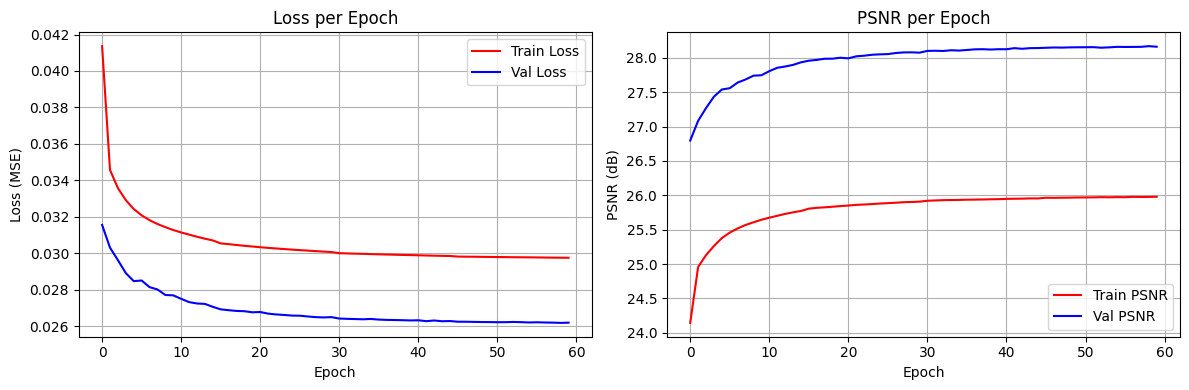

0

In [3]:
train_model_sr(
    model=model,
    model_name="EDSR",
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=num_epochs,
    scale_factor=4,
    model_requires_upscale=False,
    best_model_path=best_model_path,
    last_model_path=last_model_path,
    history_path=history_path,
    mode="scratch",        
    use_amp=True,
    scaler=None
)

/home/jadli/Bureau/BDAI2/Satellite_Super_Resulotion0/src/utils/train_model_sr.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, m

Loading LAST checkpoint: src/models/checkpoints/EDSR/last_EDSR.pth
 Resume from epoch 60 | Best PSNR = 28.17
 Loading training history...

 [EDSR] Epoch 61/80


 New BEST model saved at epoch 61 with PSNR = 28.19
Train loss: 0.029762 | Train PSNR: 26.02 dB
Val   loss: 0.026184 | Val   PSNR: 28.19 dB
-> LR: 0.00001250

 [EDSR] Epoch 62/80


 New BEST model saved at epoch 62 with PSNR = 28.19
Train loss: 0.029753 | Train PSNR: 26.02 dB
Val   loss: 0.026166 | Val   PSNR: 28.19 dB
-> LR: 0.00001250

 [EDSR] Epoch 63/80


Train loss: 0.029746 | Train PSNR: 26.02 dB
Val   loss: 0.026189 | Val   PSNR: 28.19 dB
-> LR: 0.00001250

 [EDSR] Epoch 64/80


Train loss: 0.029741 | Train PSNR: 26.02 dB
Val   loss: 0.026229 | Val   PSNR: 28.17 dB
-> LR: 0.00001250

 [EDSR] Epoch 65/80


 New BEST model saved at epoch 65 with PSNR = 28.19
Train loss: 0.029735 | Train PSNR: 26.02 dB
Val   loss: 0.026172 | Val   PSNR: 28.19 dB
-> LR: 0.00001250

 [EDSR] Epoch 66/80


 New BEST model saved at epoch 66 with PSNR = 28.20
Train loss: 0.029729 | Train PSNR: 26.02 dB
Val   loss: 0.026171 | Val   PSNR: 28.20 dB
-> LR: 0.00001250

 [EDSR] Epoch 67/80


Train loss: 0.029724 | Train PSNR: 26.02 dB
Val   loss: 0.026163 | Val   PSNR: 28.19 dB
-> LR: 0.00001250

 [EDSR] Epoch 68/80


 New BEST model saved at epoch 68 with PSNR = 28.20
Train loss: 0.029718 | Train PSNR: 26.02 dB
Val   loss: 0.026157 | Val   PSNR: 28.20 dB
-> LR: 0.00001250

 [EDSR] Epoch 69/80


Train loss: 0.029713 | Train PSNR: 26.02 dB
Val   loss: 0.026165 | Val   PSNR: 28.19 dB
-> LR: 0.00001250

 [EDSR] Epoch 70/80


 New BEST model saved at epoch 70 with PSNR = 28.20
Train loss: 0.029707 | Train PSNR: 26.02 dB
Val   loss: 0.026131 | Val   PSNR: 28.20 dB
-> LR: 0.00001250

 [EDSR] Epoch 71/80


Train loss: 0.029702 | Train PSNR: 26.03 dB
Val   loss: 0.026139 | Val   PSNR: 28.20 dB
-> LR: 0.00001250

 [EDSR] Epoch 72/80


Train loss: 0.029698 | Train PSNR: 26.03 dB
Val   loss: 0.026174 | Val   PSNR: 28.19 dB
-> LR: 0.00001250

 [EDSR] Epoch 73/80


Train loss: 0.029691 | Train PSNR: 26.03 dB
Val   loss: 0.026126 | Val   PSNR: 28.20 dB
-> LR: 0.00001250

 [EDSR] Epoch 74/80


Train loss: 0.029686 | Train PSNR: 26.03 dB
Val   loss: 0.026129 | Val   PSNR: 28.20 dB
-> LR: 0.00001250

 [EDSR] Epoch 75/80


Train loss: 0.029681 | Train PSNR: 26.03 dB
Val   loss: 0.026134 | Val   PSNR: 28.20 dB
-> LR: 0.00001250

 [EDSR] Epoch 76/80


 New BEST model saved at epoch 76 with PSNR = 28.21
Train loss: 0.029676 | Train PSNR: 26.03 dB
Val   loss: 0.026119 | Val   PSNR: 28.21 dB
-> LR: 0.00001250

 [EDSR] Epoch 77/80


 New BEST model saved at epoch 77 with PSNR = 28.21
Train loss: 0.029670 | Train PSNR: 26.03 dB
Val   loss: 0.026104 | Val   PSNR: 28.21 dB
-> LR: 0.00001250

 [EDSR] Epoch 78/80


Train loss: 0.029664 | Train PSNR: 26.04 dB
Val   loss: 0.026130 | Val   PSNR: 28.20 dB
-> LR: 0.00001250

 [EDSR] Epoch 79/80


 New BEST model saved at epoch 79 with PSNR = 28.21
Train loss: 0.029659 | Train PSNR: 26.04 dB
Val   loss: 0.026089 | Val   PSNR: 28.21 dB
-> LR: 0.00001250

 [EDSR] Epoch 80/80


 New BEST model saved at epoch 80 with PSNR = 28.22
Train loss: 0.029655 | Train PSNR: 26.04 dB
Val   loss: 0.026089 | Val   PSNR: 28.22 dB
-> LR: 0.00001250


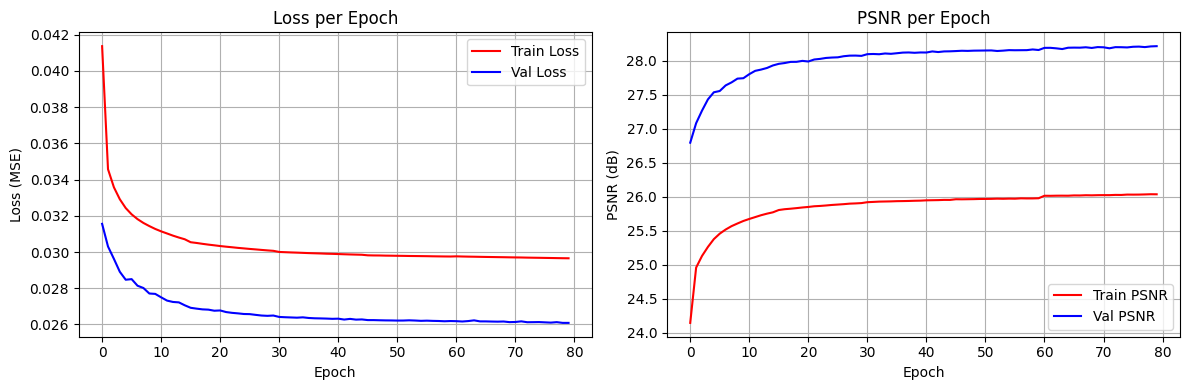

0

In [3]:
train_model_sr(
    model=model,
    model_name="EDSR",
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=num_epochs,
    scale_factor=4,
    model_requires_upscale=False,
    best_model_path=best_model_path,
    last_model_path=last_model_path,
    history_path=history_path,
    mode="resume",        
    use_amp=True,
    scaler=None
)

/home/jadli/Bureau/BDAI2/Satellite_Super_Resulotion0/src/utils/train_model_sr.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, m

Loading LAST checkpoint: src/models/checkpoints/EDSR/last_EDSR.pth
 Resume from epoch 80 | Best PSNR = 28.22
 Loading training history...

 [EDSR] Epoch 81/150


Train loss: 0.029648 | Train PSNR: 26.04 dB
Val   loss: 0.026094 | Val   PSNR: 28.21 dB
-> LR: 0.00001250

 [EDSR] Epoch 82/150


Train loss: 0.029642 | Train PSNR: 26.04 dB
Val   loss: 0.026104 | Val   PSNR: 28.21 dB
-> LR: 0.00001250

 [EDSR] Epoch 83/150


 New BEST model saved at epoch 83 with PSNR = 28.22
Train loss: 0.029635 | Train PSNR: 26.04 dB
Val   loss: 0.026084 | Val   PSNR: 28.22 dB
-> LR: 0.00001250

 [EDSR] Epoch 84/150


Train loss: 0.029627 | Train PSNR: 26.05 dB
Val   loss: 0.026084 | Val   PSNR: 28.21 dB
-> LR: 0.00001250

 [EDSR] Epoch 85/150


Train loss: 0.029620 | Train PSNR: 26.05 dB
Val   loss: 0.026112 | Val   PSNR: 28.21 dB
-> LR: 0.00001250

 [EDSR] Epoch 86/150


Train loss: 0.029610 | Train PSNR: 26.05 dB
Val   loss: 0.026092 | Val   PSNR: 28.21 dB
-> LR: 0.00001250

 [EDSR] Epoch 87/150


Train loss: 0.029600 | Train PSNR: 26.06 dB
Val   loss: 0.026072 | Val   PSNR: 28.22 dB
-> LR: 0.00001250

 [EDSR] Epoch 88/150


Train loss: 0.029587 | Train PSNR: 26.07 dB
Val   loss: 0.026082 | Val   PSNR: 28.22 dB
-> LR: 0.00001250

 [EDSR] Epoch 89/150


 New BEST model saved at epoch 89 with PSNR = 28.23
Train loss: 0.029579 | Train PSNR: 26.07 dB
Val   loss: 0.026060 | Val   PSNR: 28.23 dB
-> LR: 0.00001250

 [EDSR] Epoch 90/150


Train loss: 0.029568 | Train PSNR: 26.08 dB
Val   loss: 0.026063 | Val   PSNR: 28.22 dB
-> LR: 0.00001250

 [EDSR] Epoch 91/150


Train loss: 0.029560 | Train PSNR: 26.08 dB
Val   loss: 0.026086 | Val   PSNR: 28.22 dB
-> LR: 0.00001250

 [EDSR] Epoch 92/150


Train loss: 0.029550 | Train PSNR: 26.09 dB
Val   loss: 0.026069 | Val   PSNR: 28.22 dB
-> LR: 0.00001250

 [EDSR] Epoch 93/150


Train loss: 0.029543 | Train PSNR: 26.09 dB
Val   loss: 0.026077 | Val   PSNR: 28.22 dB
-> LR: 0.00001250

 [EDSR] Epoch 94/150


Train loss: 0.029535 | Train PSNR: 26.10 dB
Val   loss: 0.026064 | Val   PSNR: 28.22 dB
-> LR: 0.00001250

 [EDSR] Epoch 95/150


Train loss: 0.029527 | Train PSNR: 26.10 dB
Val   loss: 0.026041 | Val   PSNR: 28.23 dB
-> LR: 0.00001250

 [EDSR] Epoch 96/150


Train loss: 0.029518 | Train PSNR: 26.10 dB
Val   loss: 0.026062 | Val   PSNR: 28.22 dB
-> LR: 0.00001250

 [EDSR] Epoch 97/150


Train loss: 0.029513 | Train PSNR: 26.11 dB
Val   loss: 0.026045 | Val   PSNR: 28.23 dB
-> LR: 0.00001250

 [EDSR] Epoch 98/150


Train loss: 0.029506 | Train PSNR: 26.11 dB
Val   loss: 0.026051 | Val   PSNR: 28.23 dB
-> LR: 0.00001250

 [EDSR] Epoch 99/150


Train loss: 0.029499 | Train PSNR: 26.11 dB
Val   loss: 0.026044 | Val   PSNR: 28.22 dB
-> LR: 0.00001250

 [EDSR] Epoch 100/150


 New BEST model saved at epoch 100 with PSNR = 28.23
Train loss: 0.029493 | Train PSNR: 26.12 dB
Val   loss: 0.026047 | Val   PSNR: 28.23 dB
-> LR: 0.00001250

 [EDSR] Epoch 101/150


Train loss: 0.029486 | Train PSNR: 26.12 dB
Val   loss: 0.026036 | Val   PSNR: 28.23 dB
-> LR: 0.00001250

 [EDSR] Epoch 102/150


Train loss: 0.029481 | Train PSNR: 26.12 dB
Val   loss: 0.026086 | Val   PSNR: 28.22 dB
-> LR: 0.00001250

 [EDSR] Epoch 103/150


Train loss: 0.029474 | Train PSNR: 26.12 dB
Val   loss: 0.026045 | Val   PSNR: 28.23 dB
-> LR: 0.00001250

 [EDSR] Epoch 104/150


 New BEST model saved at epoch 104 with PSNR = 28.23
Train loss: 0.029467 | Train PSNR: 26.13 dB
Val   loss: 0.026049 | Val   PSNR: 28.23 dB
-> LR: 0.00001250

 [EDSR] Epoch 105/150


Train loss: 0.029459 | Train PSNR: 26.13 dB
Val   loss: 0.026067 | Val   PSNR: 28.22 dB
-> LR: 0.00001250

 [EDSR] Epoch 106/150


Train loss: 0.029456 | Train PSNR: 26.13 dB
Val   loss: 0.026029 | Val   PSNR: 28.23 dB
-> LR: 0.00001250

 [EDSR] Epoch 107/150


 New BEST model saved at epoch 107 with PSNR = 28.25
Train loss: 0.029451 | Train PSNR: 26.13 dB
Val   loss: 0.025995 | Val   PSNR: 28.25 dB
-> LR: 0.00001250

 [EDSR] Epoch 108/150


Train loss: 0.029447 | Train PSNR: 26.13 dB
Val   loss: 0.026045 | Val   PSNR: 28.23 dB
-> LR: 0.00001250

 [EDSR] Epoch 109/150


Train loss: 0.029441 | Train PSNR: 26.13 dB
Val   loss: 0.026035 | Val   PSNR: 28.23 dB
-> LR: 0.00001250

 [EDSR] Epoch 110/150


Train loss: 0.029435 | Train PSNR: 26.14 dB
Val   loss: 0.026019 | Val   PSNR: 28.24 dB
-> LR: 0.00001250

 [EDSR] Epoch 111/150


Train loss: 0.029432 | Train PSNR: 26.14 dB
Val   loss: 0.026022 | Val   PSNR: 28.23 dB
-> LR: 0.00001250

 [EDSR] Epoch 112/150


Train loss: 0.029426 | Train PSNR: 26.14 dB
Val   loss: 0.026050 | Val   PSNR: 28.23 dB
-> LR: 0.00001250

 [EDSR] Epoch 113/150


Train loss: 0.029420 | Train PSNR: 26.14 dB
Val   loss: 0.026009 | Val   PSNR: 28.24 dB
-> LR: 0.00001250

 [EDSR] Epoch 114/150


Train loss: 0.029417 | Train PSNR: 26.15 dB
Val   loss: 0.026043 | Val   PSNR: 28.23 dB
-> LR: 0.00001250

 [EDSR] Epoch 115/150


Train loss: 0.029411 | Train PSNR: 26.14 dB
Val   loss: 0.025995 | Val   PSNR: 28.24 dB
-> LR: 0.00001250

 [EDSR] Epoch 116/150


Train loss: 0.029406 | Train PSNR: 26.15 dB
Val   loss: 0.025999 | Val   PSNR: 28.24 dB
-> LR: 0.00001250

 [EDSR] Epoch 117/150


Train loss: 0.029403 | Train PSNR: 26.15 dB
Val   loss: 0.026037 | Val   PSNR: 28.23 dB
-> LR: 0.00001250

 [EDSR] Epoch 118/150


Train loss: 0.029398 | Train PSNR: 26.15 dB
Val   loss: 0.026007 | Val   PSNR: 28.24 dB
-> LR: 0.00001250

 [EDSR] Epoch 119/150


Train loss: 0.029397 | Train PSNR: 26.15 dB
Val   loss: 0.025983 | Val   PSNR: 28.25 dB
-> LR: 0.00001250

 [EDSR] Epoch 120/150


Train loss: 0.029390 | Train PSNR: 26.16 dB
Val   loss: 0.026004 | Val   PSNR: 28.24 dB
-> LR: 0.00001250

 [EDSR] Epoch 121/150


Train loss: 0.029387 | Train PSNR: 26.16 dB
Val   loss: 0.025994 | Val   PSNR: 28.24 dB
-> LR: 0.00001250

 [EDSR] Epoch 122/150


Train loss: 0.029382 | Train PSNR: 26.16 dB
Val   loss: 0.025986 | Val   PSNR: 28.25 dB
-> LR: 0.00001250

 [EDSR] Epoch 123/150


 New BEST model saved at epoch 123 with PSNR = 28.25
Train loss: 0.029376 | Train PSNR: 26.16 dB
Val   loss: 0.025968 | Val   PSNR: 28.25 dB
-> LR: 0.00001250

 [EDSR] Epoch 124/150


Train loss: 0.029373 | Train PSNR: 26.16 dB
Val   loss: 0.025999 | Val   PSNR: 28.24 dB
-> LR: 0.00001250

 [EDSR] Epoch 125/150


Train loss: 0.029369 | Train PSNR: 26.16 dB
Val   loss: 0.026000 | Val   PSNR: 28.24 dB
-> LR: 0.00001250

 [EDSR] Epoch 126/150


Train loss: 0.029365 | Train PSNR: 26.16 dB
Val   loss: 0.025986 | Val   PSNR: 28.24 dB
-> LR: 0.00001250

 [EDSR] Epoch 127/150


Train loss: 0.029361 | Train PSNR: 26.16 dB
Val   loss: 0.026013 | Val   PSNR: 28.24 dB
-> LR: 0.00001250

 [EDSR] Epoch 128/150


Train loss: 0.029355 | Train PSNR: 26.17 dB
Val   loss: 0.026009 | Val   PSNR: 28.24 dB
-> LR: 0.00001250

 [EDSR] Epoch 129/150


Train loss: 0.029350 | Train PSNR: 26.17 dB
Val   loss: 0.025964 | Val   PSNR: 28.25 dB
-> LR: 0.00001250

 [EDSR] Epoch 130/150


Train loss: 0.029350 | Train PSNR: 26.17 dB
Val   loss: 0.025992 | Val   PSNR: 28.25 dB
-> LR: 0.00001250

 [EDSR] Epoch 131/150


Train loss: 0.029346 | Train PSNR: 26.17 dB
Val   loss: 0.025979 | Val   PSNR: 28.24 dB
-> LR: 0.00001250

 [EDSR] Epoch 132/150


 New BEST model saved at epoch 132 with PSNR = 28.26
Train loss: 0.029341 | Train PSNR: 26.17 dB
Val   loss: 0.025943 | Val   PSNR: 28.26 dB
-> LR: 0.00001250

 [EDSR] Epoch 133/150


Train loss: 0.029336 | Train PSNR: 26.17 dB
Val   loss: 0.025967 | Val   PSNR: 28.25 dB
-> LR: 0.00001250

 [EDSR] Epoch 134/150


Train loss: 0.029334 | Train PSNR: 26.17 dB
Val   loss: 0.025964 | Val   PSNR: 28.25 dB
-> LR: 0.00001250

 [EDSR] Epoch 135/150


 New BEST model saved at epoch 135 with PSNR = 28.26
Train loss: 0.029329 | Train PSNR: 26.18 dB
Val   loss: 0.025942 | Val   PSNR: 28.26 dB
-> LR: 0.00001250

 [EDSR] Epoch 136/150


 New BEST model saved at epoch 136 with PSNR = 28.27
Train loss: 0.029325 | Train PSNR: 26.18 dB
Val   loss: 0.025929 | Val   PSNR: 28.27 dB
-> LR: 0.00001250

 [EDSR] Epoch 137/150


Train loss: 0.029325 | Train PSNR: 26.18 dB
Val   loss: 0.025961 | Val   PSNR: 28.25 dB
-> LR: 0.00001250

 [EDSR] Epoch 138/150


Train loss: 0.029317 | Train PSNR: 26.18 dB
Val   loss: 0.025952 | Val   PSNR: 28.25 dB
-> LR: 0.00001250

 [EDSR] Epoch 139/150


Train loss: 0.029314 | Train PSNR: 26.18 dB
Val   loss: 0.025935 | Val   PSNR: 28.26 dB
-> LR: 0.00001250

 [EDSR] Epoch 140/150


Train loss: 0.029311 | Train PSNR: 26.18 dB
Val   loss: 0.025952 | Val   PSNR: 28.26 dB
-> LR: 0.00001250

 [EDSR] Epoch 141/150


 New BEST model saved at epoch 141 with PSNR = 28.27
Train loss: 0.029310 | Train PSNR: 26.18 dB
Val   loss: 0.025906 | Val   PSNR: 28.27 dB
-> LR: 0.00001250

 [EDSR] Epoch 142/150


 New BEST model saved at epoch 142 with PSNR = 28.27
Train loss: 0.029307 | Train PSNR: 26.18 dB
Val   loss: 0.025901 | Val   PSNR: 28.27 dB
-> LR: 0.00001250

 [EDSR] Epoch 143/150


Train loss: 0.029299 | Train PSNR: 26.19 dB
Val   loss: 0.026001 | Val   PSNR: 28.24 dB
-> LR: 0.00001250

 [EDSR] Epoch 144/150


Train loss: 0.029299 | Train PSNR: 26.18 dB
Val   loss: 0.025942 | Val   PSNR: 28.26 dB
-> LR: 0.00001250

 [EDSR] Epoch 145/150


Train loss: 0.029294 | Train PSNR: 26.19 dB
Val   loss: 0.025931 | Val   PSNR: 28.26 dB
-> LR: 0.00001250

 [EDSR] Epoch 146/150


Train loss: 0.029288 | Train PSNR: 26.19 dB
Val   loss: 0.025938 | Val   PSNR: 28.26 dB
-> LR: 0.00001250

 [EDSR] Epoch 147/150


Train loss: 0.029287 | Train PSNR: 26.19 dB
Val   loss: 0.025922 | Val   PSNR: 28.27 dB
-> LR: 0.00001250

 [EDSR] Epoch 148/150


Train loss: 0.029284 | Train PSNR: 26.19 dB
Val   loss: 0.025945 | Val   PSNR: 28.26 dB
-> LR: 0.00001250

 [EDSR] Epoch 149/150


Train loss: 0.029280 | Train PSNR: 26.19 dB
Val   loss: 0.025928 | Val   PSNR: 28.26 dB
-> LR: 0.00001250

 [EDSR] Epoch 150/150


 New BEST model saved at epoch 150 with PSNR = 28.28
Train loss: 0.029276 | Train PSNR: 26.19 dB
Val   loss: 0.025883 | Val   PSNR: 28.28 dB
-> LR: 0.00001250


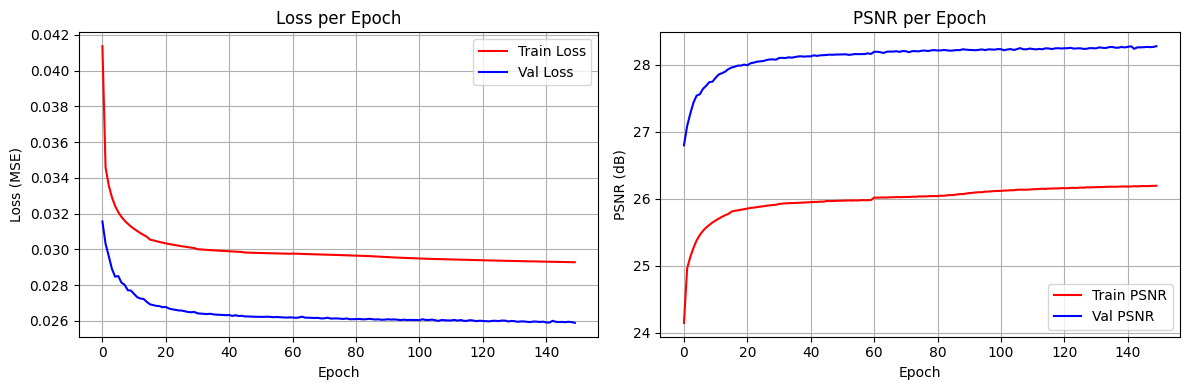

0

In [2]:
train_model_sr(
    model=model,
    model_name="EDSR",
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=num_epochs,
    scale_factor=4,
    model_requires_upscale=False,
    best_model_path=best_model_path,
    last_model_path=last_model_path,
    history_path=history_path,
    mode="resume",        
    use_amp=True,
    scaler=None
)